# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import random
import os
import sys
from PIL import Image, ImageDraw
import torchvision.transforms as T
import json
import torchvision
sys.path.append("/data/mwoedlinger/code/segment-anything")

## Load Faster RCNN

In [2]:
# Load faster RCNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT")
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

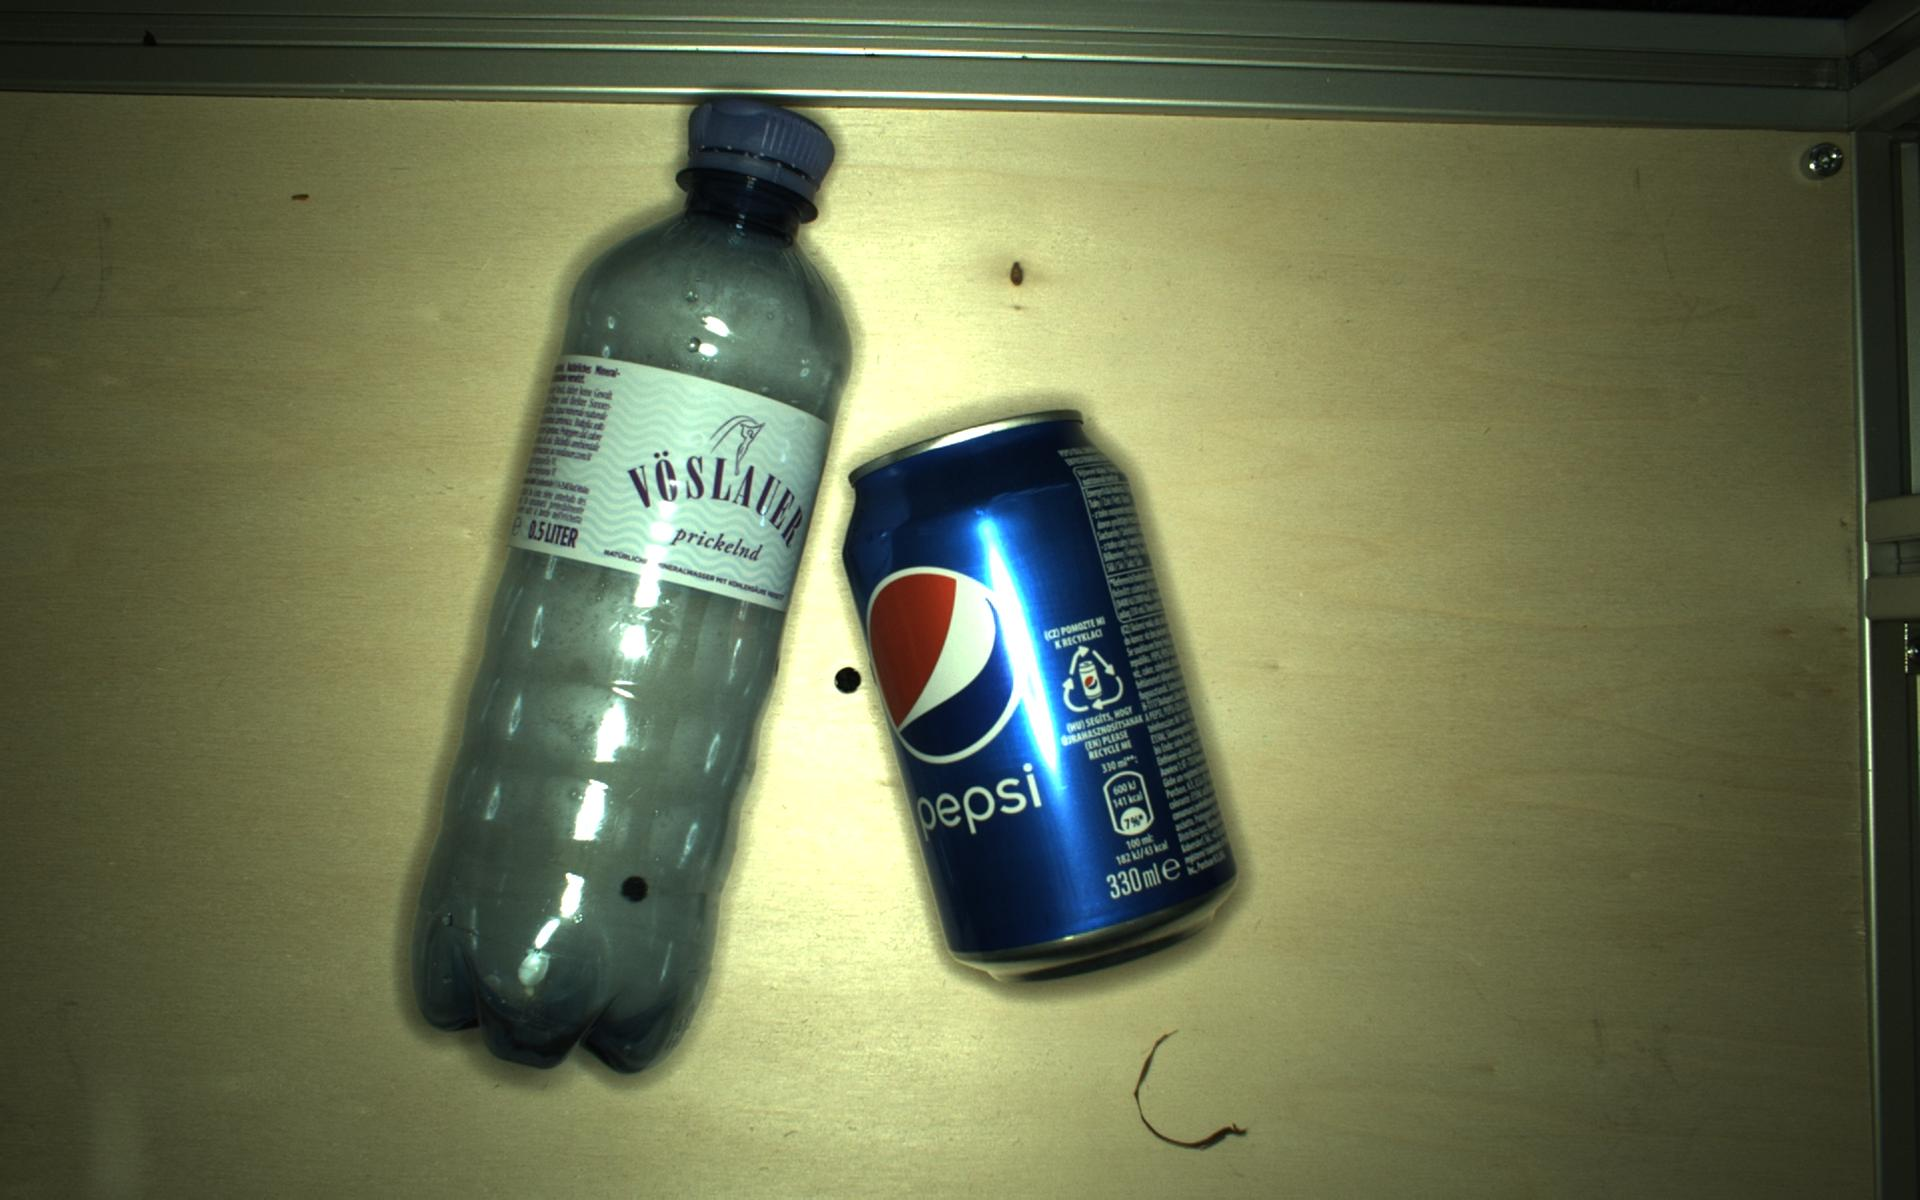

In [3]:
image_path = "/data/mwoedlinger/code/sustainibility-hackathon/sample_data2/data/image0000004.jpg"

# Load image
image = Image.open(image_path).convert("RGB")
image.show()


In [4]:
!nvidia-smi

Fri Jun  2 20:13:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 31%   52C    P2   123W / 350W |   5337MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:25:00.0 Off |                  N/A |
| 30%   

In [5]:
model.to(torch.device('cuda:4'))

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

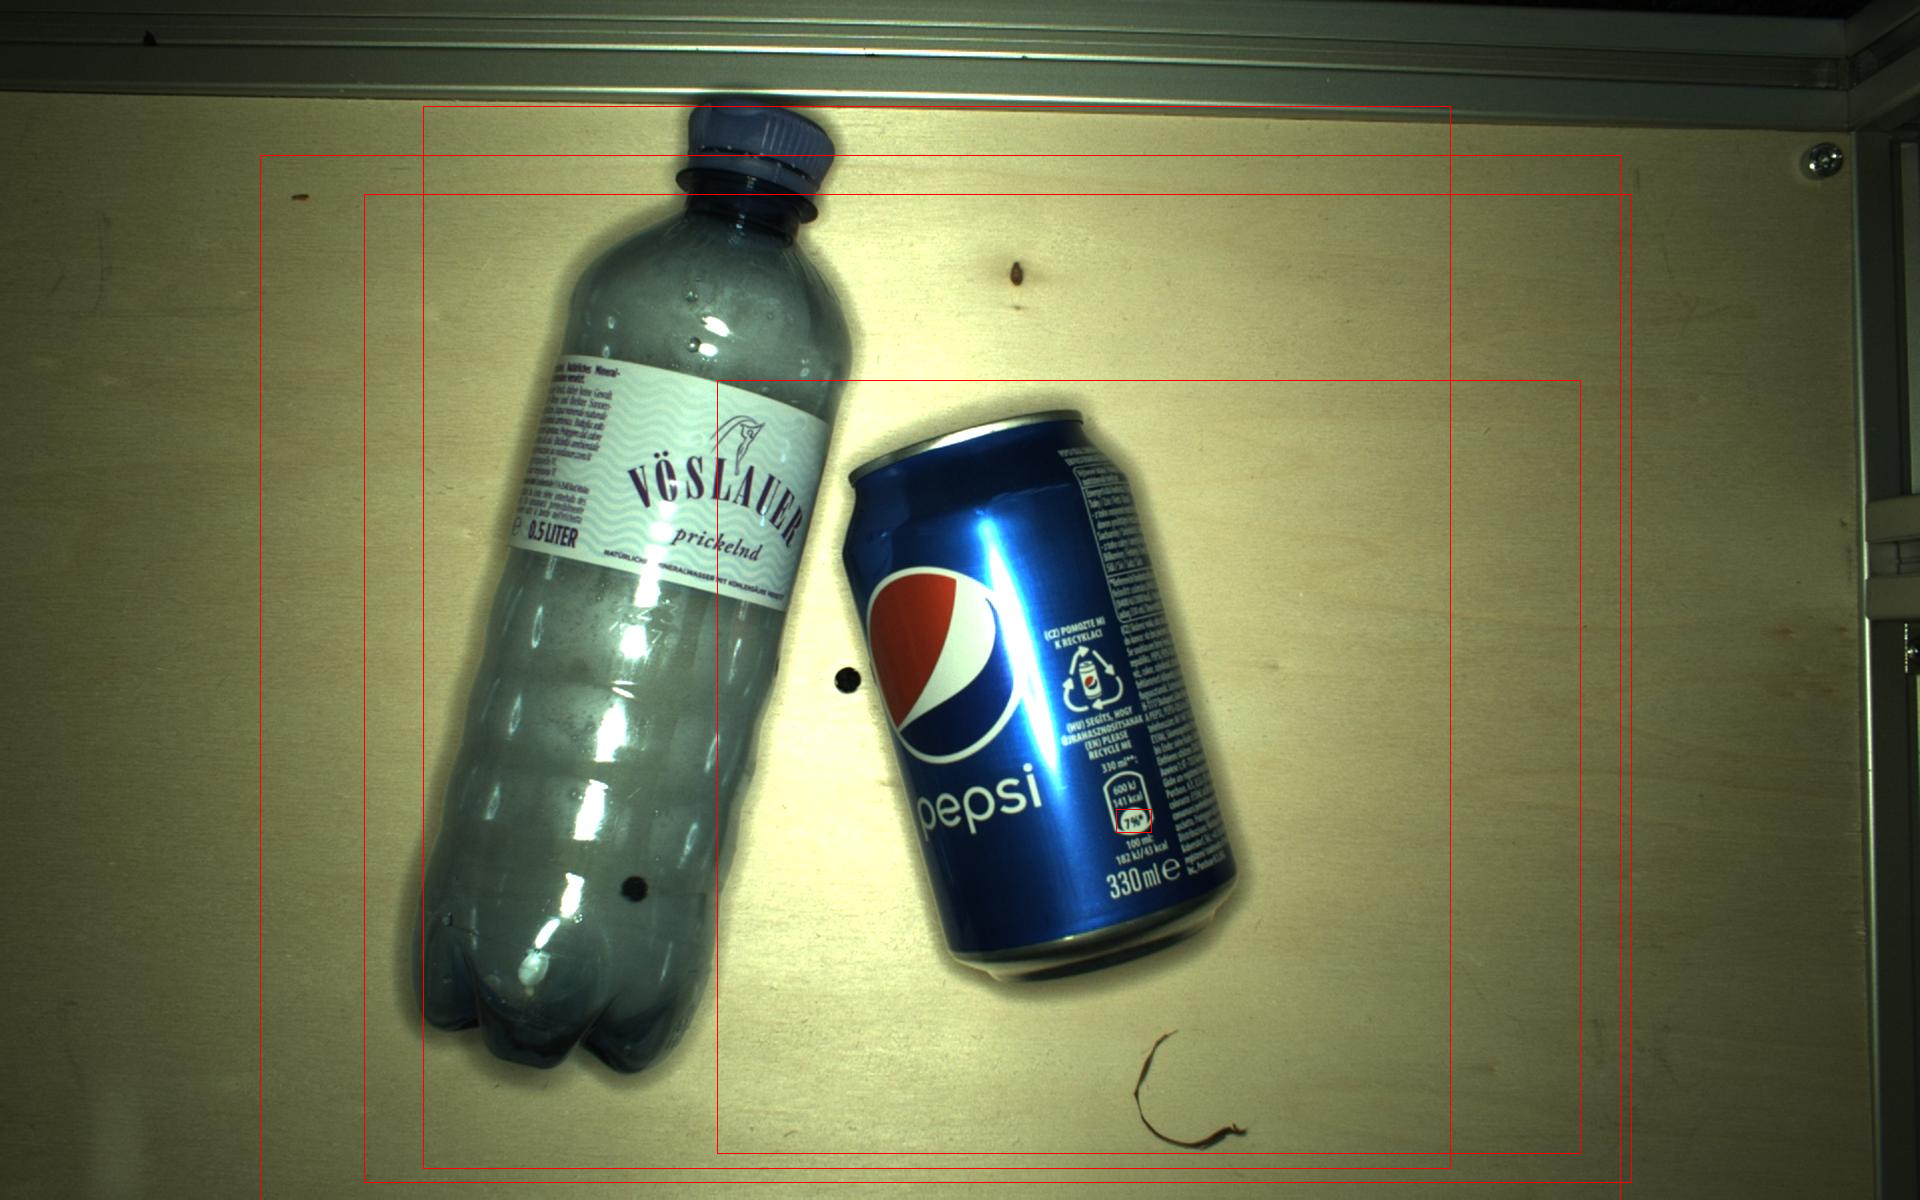

In [7]:
# Run image though network

# Convert image to tensor
image_tensor = T.ToTensor()(image)

# normalize image
image_tensor = T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])(image_tensor).to(torch.device('cuda:4'))

# Run image through network
output = model([image_tensor])

# Get bounding boxes
boxes = output[0]["boxes"].cpu().detach().numpy()
boxes = boxes.astype(int)

# Get labels
labels = output[0]["labels"].cpu().detach().numpy()

# Get scores
scores = output[0]["scores"].cpu().detach().numpy()

# visualize results with pillow
draw = ImageDraw.Draw(image)
for i in range(len(boxes)):
    if scores[i] > 0.1:
        draw.rectangle(((boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3])), outline="red")
        #draw.text((boxes[i][0], boxes[i][1]), str(labels[i]) + " " + str(scores[i]), fill="red")
image.show()


## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [8]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=125):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Selecting objects with SAM

In [9]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/data/mwoedlinger/code/segment-anything/weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda:4"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [10]:
im = np.array(Image.open(image_path).convert("RGB"))

predictor.set_image(im)

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [11]:
input_points = []
input_labels = []
for xmin, ymin, xmax, ymax in boxes.tolist():
    input_points.append([(xmin+xmax)/2, (ymin+ymax)/2])
    input_labels.append(1)

input_point = np.array(input_points)#np.array([[450, 220]])
input_label = np.array(input_labels)#np.array([1])

input_point = np.array([[255, 550], [800, 300], [600, 550], [600, 200], [100, 550], [560, 500], [170, 480], [170, 420], [65, 110], [590, 150], [360, 35], [50, 400]])#np.array([[450, 220]])
input_label = np.array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])#np.array([1])

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [12]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [13]:
masks.shape  # (number_of_masks) x H x W

(3, 1200, 1920)

In [14]:
im_numpy = np.array(Image.open(image_path).convert("RGB"))

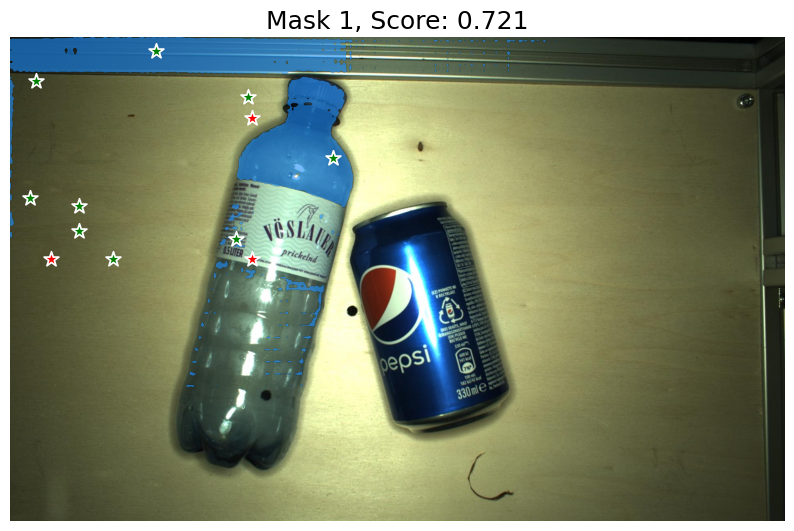

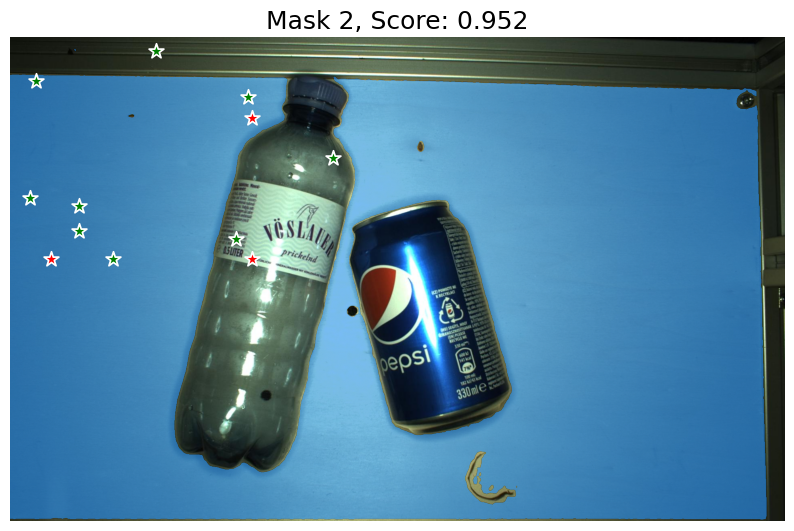

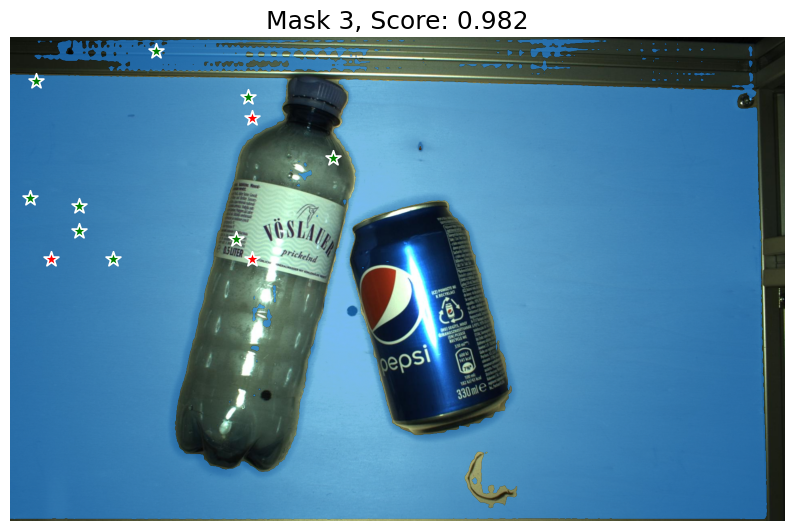

In [15]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(im_numpy)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

## Specifying a specific object with additional points

In [16]:
input_points = []
input_labels = []
for xmin, ymin, xmax, ymax in boxes.tolist():
    input_points.append([(xmin+xmax)/2, (ymin+ymax)/2])
    input_labels.append(1)

input_points.extend([[400, 600], [800, 400]])
input_labels.extend([0,0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

input_points_np = np.array(input_points)#np.array([[450, 220]])
input_label_np = np.array(input_labels)#np.array([1])

In [17]:
masks, _, _ = predictor.predict(
    point_coords=input_points_np,
    point_labels=input_label_np,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

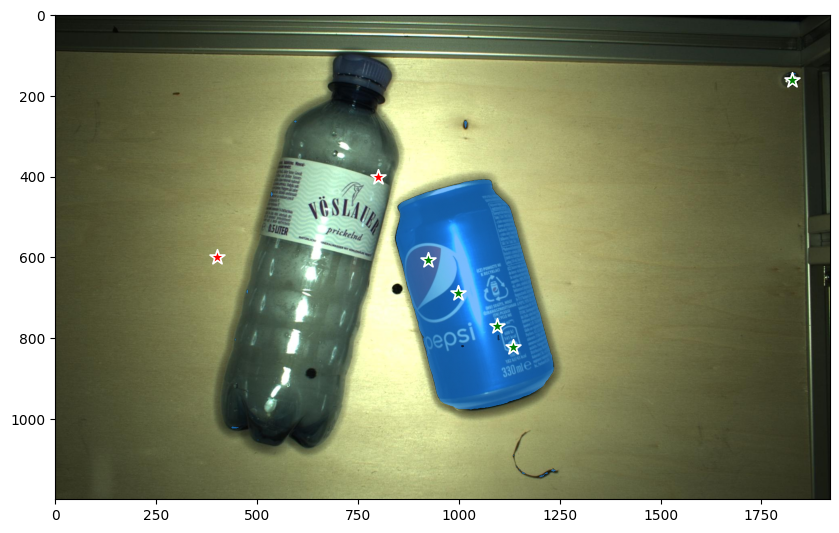

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(im)
show_mask(masks, plt.gca())
show_points(input_points_np, input_label_np, plt.gca())
plt.show() 

## Batched prompt inputs

SamPredictor can take multiple input prompts for the same image, using `predict_torch` method. This method assumes input points are already torch tensors and have already been transformed to the input frame. For example, imagine we have several box outputs from an object detector.

In [19]:
# input_boxes = torch.tensor([
#     [75, 275, 1725, 850],
#     [425, 600, 700, 875],
#     [1375, 550, 1650, 800],
#     [1240, 675, 1400, 750],
# ], device=predictor.device)
# bboxes_scaled
# print(bboxes_scaled.shape)
input_boxes = torch.from_numpy(boxes)
input_boxes = input_boxes.to(predictor.device)

Transform the boxes to the input frame, then predict masks. `SamPredictor` stores the necessary transform as the `transform` field for easy access, though it can also be instantiated directly for use in e.g. a dataloader (see `segment_anything.utils.transforms`).

In [23]:
input_boxes

tensor([[ 364,  194, 1631, 1182],
        [1118,  811, 1150,  834],
        [ 464,   35, 1383, 1180],
        [ 704,  398, 1487, 1144],
        [1803,  138, 1846,  185]], device='cuda:4')

In [20]:
bboxes_ = input_boxes

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, im.shape[1:])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [21]:
masks.shape # (batch_size) x (num_predicted_masks_per_input) x H x W

torch.Size([5, 1, 1200, 1920])

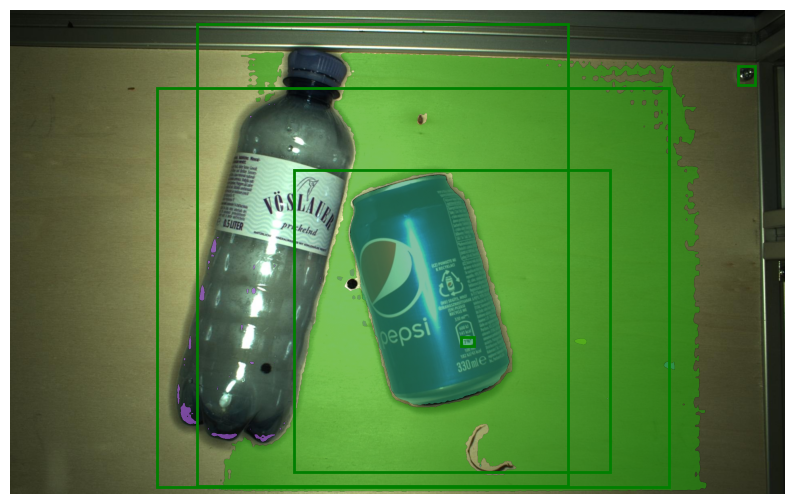

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(im_numpy)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

## End-to-end batched inference

If all prompts are available in advance, it is possible to run SAM directly in an end-to-end fashion. This also allows batching over images.

In [49]:
image1 = image  # truck.jpg from above
image1_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=sam.device)

image2 = cv2.imread('images/groceries.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2_boxes = torch.tensor([
    [450, 170, 520, 350],
    [350, 190, 450, 350],
    [500, 170, 580, 350],
    [580, 170, 640, 350],
], device=sam.device)

[ WARN:0@821.396] global loadsave.cpp:244 findDecoder imread_('images/groceries.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


Both images and prompts are input as PyTorch tensors that are already transformed to the correct frame. Inputs are packaged as a list over images, which each element is a dict that takes the following keys:
* `image`: The input image as a PyTorch tensor in CHW format.
* `original_size`: The size of the image before transforming for input to SAM, in (H, W) format.
* `point_coords`: Batched coordinates of point prompts.
* `point_labels`: Batched labels of point prompts.
* `boxes`: Batched input boxes.
* `mask_inputs`: Batched input masks.

If a prompt is not present, the key can be excluded.

In [ ]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device) 
    return image.permute(2, 0, 1).contiguous()

In [ ]:
batched_input = [
     {
         'image': prepare_image(image1, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image1_boxes, image1.shape[:2]),
         'original_size': image1.shape[:2]
     },
     {
         'image': prepare_image(image2, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image2_boxes, image2.shape[:2]),
         'original_size': image2.shape[:2]
     }
]

Run the model.

In [ ]:
batched_output = sam(batched_input, multimask_output=False)

The output is a list over results for each input image, where list elements are dictionaries with the following keys:
* `masks`: A batched torch tensor of predicted binary masks, the size of the original image.
* `iou_predictions`: The model's prediction of the quality for each mask.
* `low_res_logits`: Low res logits for each mask, which can be passed back to the model as mask input on a later iteration.

In [ ]:
batched_output[0].keys()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(image1)
for mask in batched_output[0]['masks']:
    show_mask(mask.cpu().numpy(), ax[0], random_color=True)
for box in image1_boxes:
    show_box(box.cpu().numpy(), ax[0])
ax[0].axis('off')

ax[1].imshow(image2)
for mask in batched_output[1]['masks']:
    show_mask(mask.cpu().numpy(), ax[1], random_color=True)
for box in image2_boxes:
    show_box(box.cpu().numpy(), ax[1])
ax[1].axis('off')

plt.tight_layout()
plt.show()